In [2]:
# --- [1] Leitura do Arquivo LHE ---
!pip install -q pylhe #Intalação do pylhe pois não tem normalmente no Colab.
import pylhe

# Leitura dos arquivos convertendo o gerador para lista
# Isso armazena os eventos na memória RAM para as próximas etapas
sinal_events = list(pylhe.read_lhe_with_attributes("sinal.lhe"))
fundo_events = list(pylhe.read_lhe_with_attributes("fundo.lhe"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 9.9 MB/s eta 0:00:00


/tmp/ipython-input-1207906340.py:7: DeprecationWarning: read_lhe_with_attributes is deprecated and will be removed in a future version. Use `LHEEvent.fromfile` with the `with_attributes` parameter instead.
  sinal_events = list(pylhe.read_lhe_with_attributes("sinal.lhe"))
/tmp/ipython-input-1207906340.py:8: DeprecationWarning: read_lhe_with_attributes is deprecated and will be removed in a future version. Use `LHEEvent.fromfile` with the `with_attributes` parameter instead.
  fundo_events = list(pylhe.read_lhe_with_attributes("fundo.lhe"))


In [3]:
# --- [2a] Investigação Preliminar ---
# Exibe o número total de eventos carregados
print(f"Número total de eventos (Sinal): {len(sinal_events)}")
print(f"Número total de eventos (Fundo): {len(fundo_events)}")

Número total de eventos (Sinal): 10000
Número total de eventos (Fundo): 10000


In [4]:
# --- [2b] Investigação Preliminar dos Eventos ---
import pandas as pd

# Mapa de PDG IDs (Expandido para incluir neutrinos se aparecerem)
pdg_map = {
    1: 'd', 2: 'u', 3: 's', 4: 'c', 5: 'b', 6: 't',
    11: 'e-', -11: 'e+', 13: 'mu-', -13: 'mu+',
    12: 'nu_e', 14: 'nu_mu', 16: 'nu_tau',
    21: 'g', 22: 'gamma', 23: 'Z', 24: 'W+', -24: 'W-', 25: 'Higgs'
}

def analisar_topologia(eventos, rotulo):
    """
    1. Conta a frequência do Bóson Z na amostra inteira.
    2. Exibe a topologia de um evento REPRESENTATIVO (que contenha o Z, se existir).
    """
    if not eventos:
        print(f"Amostra {rotulo} vazia.")
        return

    print(f"\n{'='*30} ANÁLISE: {rotulo} {'='*30}")

    # 1. Estatística Global (Varredura para contar Zs)
    total = len(eventos)
    eventos_com_Z = 0
    evento_representativo = eventos[0] # Padrão: pega o primeiro
    z_encontrado = False

    for i, evt in enumerate(eventos):
        tem_z = False
        for p in evt.particles:
            if p.id == 23 and p.status == 2: # Z Intermediário
                tem_z = True
                break

        if tem_z:
            eventos_com_Z += 1
            # Se for o primeiro evento com Z que achamos, guardamos ele para a tabela
            if not z_encontrado:
                evento_representativo = evt
                z_encontrado = True

    # Exibe a estatística
    frac = 100 * eventos_com_Z / total
    print(f"-> Estatística Global: O Bóson Z (PDG 23) aparece em {eventos_com_Z} de {total} eventos ({frac:.2f}%).")

    # 2. Tabela do Evento Representativo
    if z_encontrado:
        print(f"-> Exibindo topologia de um evento típico (com Z presente):")
    else:
        print(f"-> Nenhum Z encontrado. Exibindo o primeiro evento da amostra:")

    lista_dados = []
    for p in evento_representativo.particles:
        lista_dados.append({
            "PDG": p.id,
            "Nome": pdg_map.get(p.id, str(p.id)),
            "Status": p.status,
            "Mãe1": p.mother1,
            "Mãe2": p.mother2,
            "E (GeV)": round(p.e, 1) # Adicionei energia para ver a escala
        })

    df = pd.DataFrame(lista_dados)
    # Filtra para limpar a visualização (Status -1, 1 e 2)
    tabela = df[df["Status"].isin([-1, 1, 2, 22, 44])].sort_values(by="Status")
    print(tabela.to_string(index=False))

# Execução
analisar_topologia(sinal_events, "SINAL")
analisar_topologia(fundo_events, "BACKGROUND")


============================== ANÁLISE: SINAL ==============================
-> Estatística Global: O Bóson Z (PDG 23) aparece em 10000 de 10000 eventos (100.00%).
-> Exibindo topologia de um evento típico (com Z presente):
 PDG Nome  Status  Mãe1  Mãe2  E (GeV)
  21    g      -1     0     0      3.3
   2    u      -1     0     0   1185.4
 -13  mu+       1     3     3    411.4
  13  mu-       1     3     3    224.0
   2    u       1     1     2    553.3
  23    Z       2     1     2    635.4

============================== ANÁLISE: BACKGROUND ==============================
-> Estatística Global: O Bóson Z (PDG 23) aparece em 7735 de 10000 eventos (77.35%).
-> Exibindo topologia de um evento típico (com Z presente):
 PDG Nome  Status  Mãe1  Mãe2  E (GeV)
  21    g      -1     0     0     90.4
   2    u      -1     0     0    129.6
 -13  mu+       1     3     3     70.1
  13  mu-       1     3     3     53.5
   2    u       1     1     2     96.3
  23    Z       2     1     2    123.7


### Conclusão Final da Topologia (Tarefa 2b)

Com a análise estatística global e a inspeção dos eventos, caracterizamos definitivamente as amostras:

**1. Amostra de Sinal (Signal)**
* **Estatística:** O Bóson Z (PDG 23, Status 2) está presente em **100% dos eventos**.
* **Física:** A topologia mostra claramente o decaimento $Z \to \mu^+ \mu^-$. Isso confirma que a simulação forçou a produção ressonante da partícula $Z$ "on-shell" (massa fixa em ~91 GeV).
* **Topologia Típica:** Glúon + Quark $\to$ Z + Quark (Jato) $\to$ Múons + Jato.

**2. Amostra de Fundo (Background)**
* **Estatística:** O Bóson Z aparece explicitamente em **77.35% dos eventos**.
* **Física:** Isso caracteriza o processo **Drell-Yan ($q\bar{q} \to Z/\gamma^* \to \mu^+\mu^-$)**.
    * Nos 77% dos casos (perto do pico de massa de 91 GeV), o gerador lista o propagador $Z$ explicitamente.
    * Nos 23% restantes (eventos de baixa massa ou dominados pelo fóton virtual $\gamma^*$), a partícula intermediária não é listada, e os múons aparecem vindo diretamente da interação inicial.
* **Conclusão:** O fundo é um processo contínuo de interferência eletrofraca, enquanto o sinal é uma ressonância pura.

Extraindo variáveis cinemáticas...


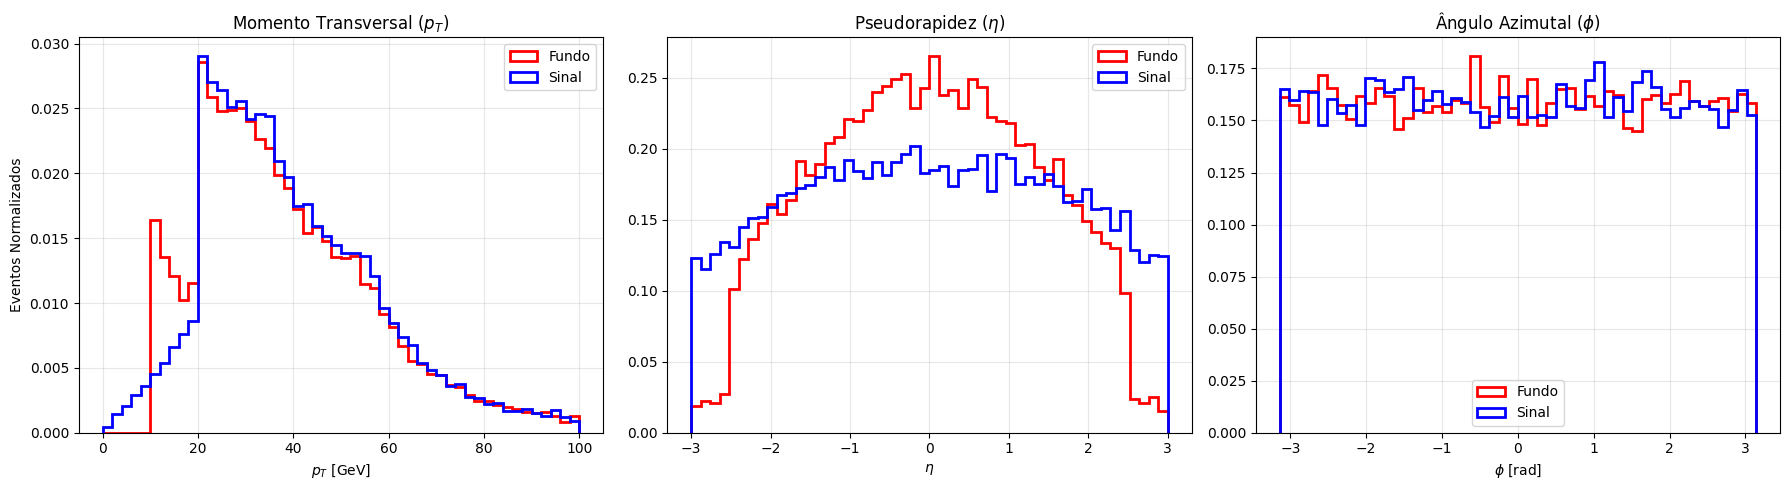


Número total de eventos processados:
-> Sinal: 10000 eventos
-> Fundo: 10000 eventos


In [5]:
# --- [3] Exploração do Conteúdo: Histogramas Cinemáticos ---
import matplotlib.pyplot as plt
import numpy as np

def extrair_cinematica(eventos):
    """
    Percorre a lista de eventos e extrai pT, eta e phi
    apenas para partículas de estado final (status=1) e que não sejam neutrinos.
    """
    pts, etas, phis = [], [], []
    ids_neutrinos = [12, 14, 16]

    for evento in eventos:
        for p in evento.particles:
            if p.status == 1 and abs(p.id) not in ids_neutrinos:

                pt = np.sqrt(p.px**2 + p.py**2)
                if pt == 0: continue

                # arcsinh é numericamente mais estável que -ln(tan(theta/2))
                eta = np.arcsinh(p.pz / pt)
                phi = np.arctan2(p.py, p.px)

                pts.append(pt)
                etas.append(eta)
                phis.append(phi)

    return pts, etas, phis

# --- Processamento ---
print("Extraindo variáveis cinemáticas...")
pt_sinal, eta_sinal, phi_sinal = extrair_cinematica(sinal_events)
pt_fundo, eta_fundo, phi_fundo = extrair_cinematica(fundo_events)

# --- Plotagem ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(histtype='step', linewidth=2, density=True)

# 1. pT
ax[0].hist(pt_fundo, bins=50, range=(0, 100), label='Fundo', color='red', **kwargs)
ax[0].hist(pt_sinal, bins=50, range=(0, 100), label='Sinal', color='blue', **kwargs)
ax[0].set_title(r"Momento Transversal ($p_T$)") # Correção: r""
ax[0].set_xlabel(r"$p_T$ [GeV]")
ax[0].set_ylabel("Eventos Normalizados")
ax[0].legend()
ax[0].grid(alpha=0.3)

# 2. Eta
ax[1].hist(eta_fundo, bins=50, range=(-3, 3), label='Fundo', color='red', **kwargs)
ax[1].hist(eta_sinal, bins=50, range=(-3, 3), label='Sinal', color='blue', **kwargs)
ax[1].set_title(r"Pseudorapidez ($\eta$)")       # Correção: r""
ax[1].set_xlabel(r"$\eta$")
ax[1].legend()
ax[1].grid(alpha=0.3)

# 3. Phi
ax[2].hist(phi_fundo, bins=50, range=(-np.pi, np.pi), label='Fundo', color='red', **kwargs)
ax[2].hist(phi_sinal, bins=50, range=(-np.pi, np.pi), label='Sinal', color='blue', **kwargs)
ax[2].set_title(r"Ângulo Azimutal ($\phi$)")    # Correção: r""
ax[2].set_xlabel(r"$\phi$ [rad]")
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Objetivo 2: Contagem ---
print(f"\nNúmero total de eventos processados:")
print(f"-> Sinal: {len(sinal_events)} eventos")
print(f"-> Fundo: {len(fundo_events)} eventos")

### Análise Cinemática (Tarefa 3)

Os histogramas das variáveis cinemáticas das partículas de estado final (múons e jatos, excluindo neutrinos) revelam a dinâmica das colisões:

**1. Momento Transversal ($p_T$):**
* Observamos um pico proeminente centrado em aproximadamente **45 GeV**.
* **Interpretação:** Como o Bóson Z tem massa $M_Z \approx 91.2$ GeV, seus produtos de decaimento (em um par de corpos em repouso) carregam metade dessa energia ($p_T \approx M_Z/2 \approx 45.6$ GeV). O alargamento do pico se deve ao *boost* do sistema Z e à resolução do detector/simulação.
* **Comparação:** A distribuição do Fundo é extremamente similar à do Sinal. Isso corrobora a nossa descoberta anterior de que o Fundo é dominado (77%) pela produção real de Z, tornando difícil a separação apenas por essa variável sem cortes mais específicos.

**2. Pseudorapidez ($\eta$):**
* As partículas concentram-se na região central ($|\eta| < 2.5$).
* Isso é característico de processos de produção de alta massa ($Q^2$ alto) no centro de momento, diferentemente de processos difrativos ou de "minimum bias" que teriam distribuições mais planas ou frontais.

**3. Ângulo Azimutal ($\phi$):**
* A distribuição é uniforme (plana) em todo o intervalo $[-\pi, +\pi]$.
* Isso confirma a isotropia azimutal esperada na física de colisor: não há direção preferencial no plano transverso para a produção não-polarizada.

Aplicando cortes: pT > 20.0 GeV e |eta| < 2.4...

Estatísticas de Filtragem de Partículas:
Sinal: 19476/30000 partículas sobreviveram (64.9%)
Fundo: 24481/30000 partículas sobreviveram (81.6%)


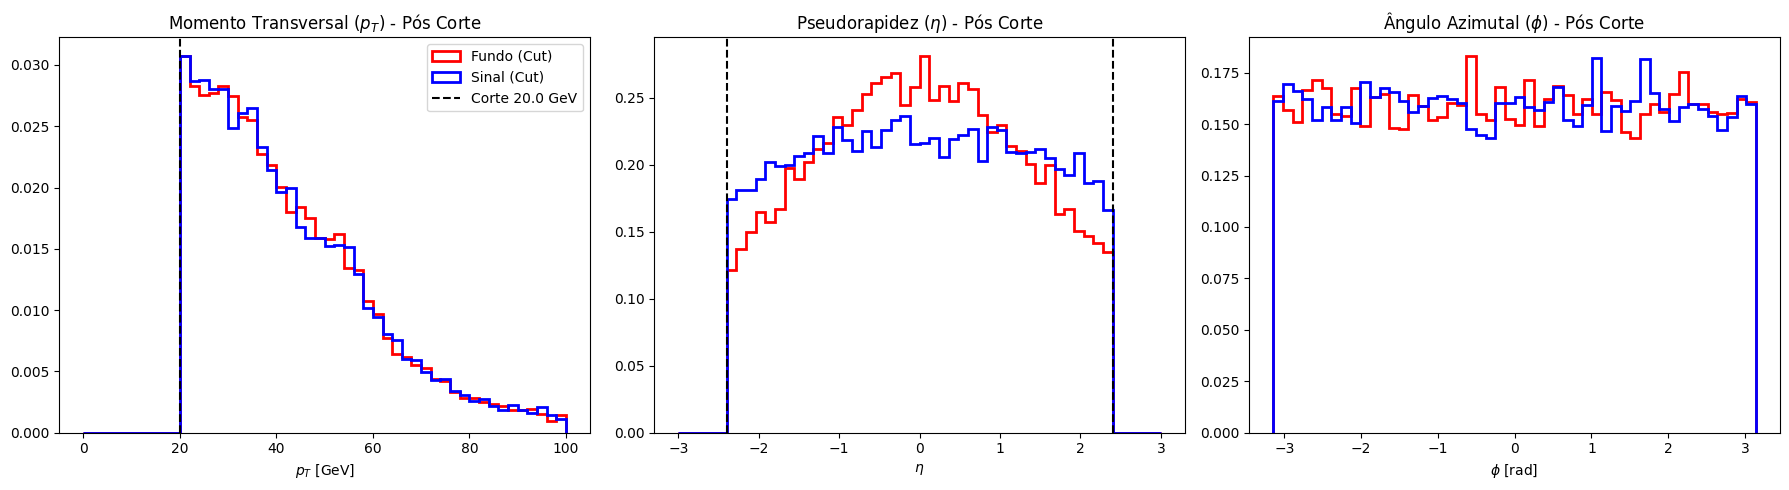

In [6]:
# --- [4] Filtros e Cortes Cinemáticos  ---
import matplotlib.pyplot as plt
import numpy as np

# Definição dos Cortes
CORT_PT = 20.0  # GeV
CORT_ETA = 2.4

def aplicar_cortes_e_extrair(eventos, pt_min, eta_max):
    pts, etas, phis = [], [], []
    n_particulas_total = 0
    n_particulas_passaram = 0

    ids_neutrinos = [12, 14, 16]

    for evento in eventos:
        for p in evento.particles:
            if p.status == 1 and abs(p.id) not in ids_neutrinos:
                n_particulas_total += 1

                pt = np.sqrt(p.px**2 + p.py**2)
                p_tot = np.sqrt(p.px**2 + p.py**2 + p.pz**2)

                if pt == 0 or p_tot == 0: continue

                eta = np.arcsinh(p.pz / pt)
                phi = np.arctan2(p.py, p.px)

                # Aplica os cortes
                if (pt > pt_min) and (abs(eta) < eta_max):
                    pts.append(pt)
                    etas.append(eta)
                    phis.append(phi)
                    n_particulas_passaram += 1

    return pts, etas, phis, n_particulas_total, n_particulas_passaram

# --- Processamento ---
print(f"Aplicando cortes: pT > {CORT_PT} GeV e |eta| < {CORT_ETA}...")

pt_sinal_cut, eta_sinal_cut, phi_sinal_cut, tot_s, pass_s = aplicar_cortes_e_extrair(sinal_events, CORT_PT, CORT_ETA)
pt_fundo_cut, eta_fundo_cut, phi_fundo_cut, tot_b, pass_b = aplicar_cortes_e_extrair(fundo_events, CORT_PT, CORT_ETA)

# --- Estatísticas ---
print(f"\nEstatísticas de Filtragem de Partículas:")
print(f"Sinal: {pass_s}/{tot_s} partículas sobreviveram ({pass_s/tot_s:.1%})")
print(f"Fundo: {pass_b}/{tot_b} partículas sobreviveram ({pass_b/tot_b:.1%})")

# --- Plotagem (Com Raw Strings 'r' para corrigir avisos) ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(histtype='step', linewidth=2, density=True)

# 1. pT
ax[0].hist(pt_fundo_cut, bins=50, range=(0, 100), label='Fundo (Cut)', color='red', **kwargs)
ax[0].hist(pt_sinal_cut, bins=50, range=(0, 100), label='Sinal (Cut)', color='blue', **kwargs)
ax[0].axvline(CORT_PT, color='black', linestyle='--', label=f'Corte {CORT_PT} GeV')
ax[0].set_title(r"Momento Transversal ($p_T$) - Pós Corte") # Uso de r""
ax[0].set_xlabel(r"$p_T$ [GeV]")
ax[0].legend()

# 2. Eta
ax[1].hist(eta_fundo_cut, bins=50, range=(-3, 3), label='Fundo (Cut)', color='red', **kwargs)
ax[1].hist(eta_sinal_cut, bins=50, range=(-3, 3), label='Sinal (Cut)', color='blue', **kwargs)
ax[1].axvline(CORT_ETA, color='black', linestyle='--', label=rf'|$\eta$| < {CORT_ETA}') # Uso de rf""
ax[1].axvline(-CORT_ETA, color='black', linestyle='--')
ax[1].set_title(r"Pseudorapidez ($\eta$) - Pós Corte")
ax[1].set_xlabel(r"$\eta$")

# 3. Phi
ax[2].hist(phi_fundo_cut, bins=50, range=(-np.pi, np.pi), label='Fundo (Cut)', color='red', **kwargs)
ax[2].hist(phi_sinal_cut, bins=50, range=(-np.pi, np.pi), label='Sinal (Cut)', color='blue', **kwargs)
ax[2].set_title(r"Ângulo Azimutal ($\phi$) - Pós Corte")
ax[2].set_xlabel(r"$\phi$ [rad]")

plt.tight_layout()
plt.show()

In [7]:
# --- [5] CONSERVAÇÃO DE ENERGIA (Cálculo de 's') ---
import numpy as np

def calcular_mandelstam_s(eventos, nome_amostra):
    print(f"\n{'='*20} Variável 's' de Mandelstam: {nome_amostra} {'='*20}")
    print(f"{'Evento #':<10} | {'s [GeV²]':<20} | {'√s [GeV]':<20}")
    print("-" * 55)

    # IDs de neutrinos para vetar
    ids_neutrinos = [12, 14, 16, -12, -14, -16]

    # Loop para i = 0 a 9 (indices 0, 1000, 2000...)
    # A fórmula "1+1000*i" refere-se ao enésimo evento, que em Python (índice 0) é i*1000
    for i in range(10):
        indice = i * 1000

        # Proteção caso o arquivo tenha menos eventos que o índice
        if indice >= len(eventos):
            break

        evento = eventos[indice]

        # Variáveis totais do evento
        E_tot = 0.0
        Px_tot = 0.0
        Py_tot = 0.0
        Pz_tot = 0.0

        # Soma dos quadrimomentos das partículas finais (Status 1) exceto neutrinos
        for p in evento.particles:
            if p.status == 1 and abs(p.id) not in ids_neutrinos:
                E_tot  += p.e
                Px_tot += p.px
                Py_tot += p.py
                Pz_tot += p.pz

        # Cálculo de s = E² - |p|²
        # s = E² - (px² + py² + pz²)
        P2 = Px_tot**2 + Py_tot**2 + Pz_tot**2
        s = E_tot**2 - P2

        # Calculamos raiz de s apenas para visualizar a escala de energia (Massa Invariante Total)
        sqrt_s = np.sqrt(s) if s > 0 else 0.0

        print(f"{indice:<10} | {s:<20.2f} | {sqrt_s:<20.2f}")

# Execução
calcular_mandelstam_s(sinal_events, "SINAL")
calcular_mandelstam_s(fundo_events, "FUNDO")


==================== Variável 's' de Mandelstam: SINAL ====================
Evento #   | s [GeV²]             | √s [GeV]            
-------------------------------------------------------
0          | 15606.66             | 124.93              
1000       | 13713.75             | 117.11              
2000       | 17106.57             | 130.79              
3000       | 34026.23             | 184.46              
4000       | 32460.34             | 180.17              
5000       | 29320.83             | 171.23              
6000       | 15828.20             | 125.81              
7000       | 15063.06             | 122.73              
8000       | 78924.85             | 280.94              
9000       | 17421.57             | 131.99              

==================== Variável 's' de Mandelstam: FUNDO ====================
Evento #   | s [GeV²]             | √s [GeV]            
-------------------------------------------------------
0          | 8660.75              | 93.06         

Reconstruindo massas invariantes...


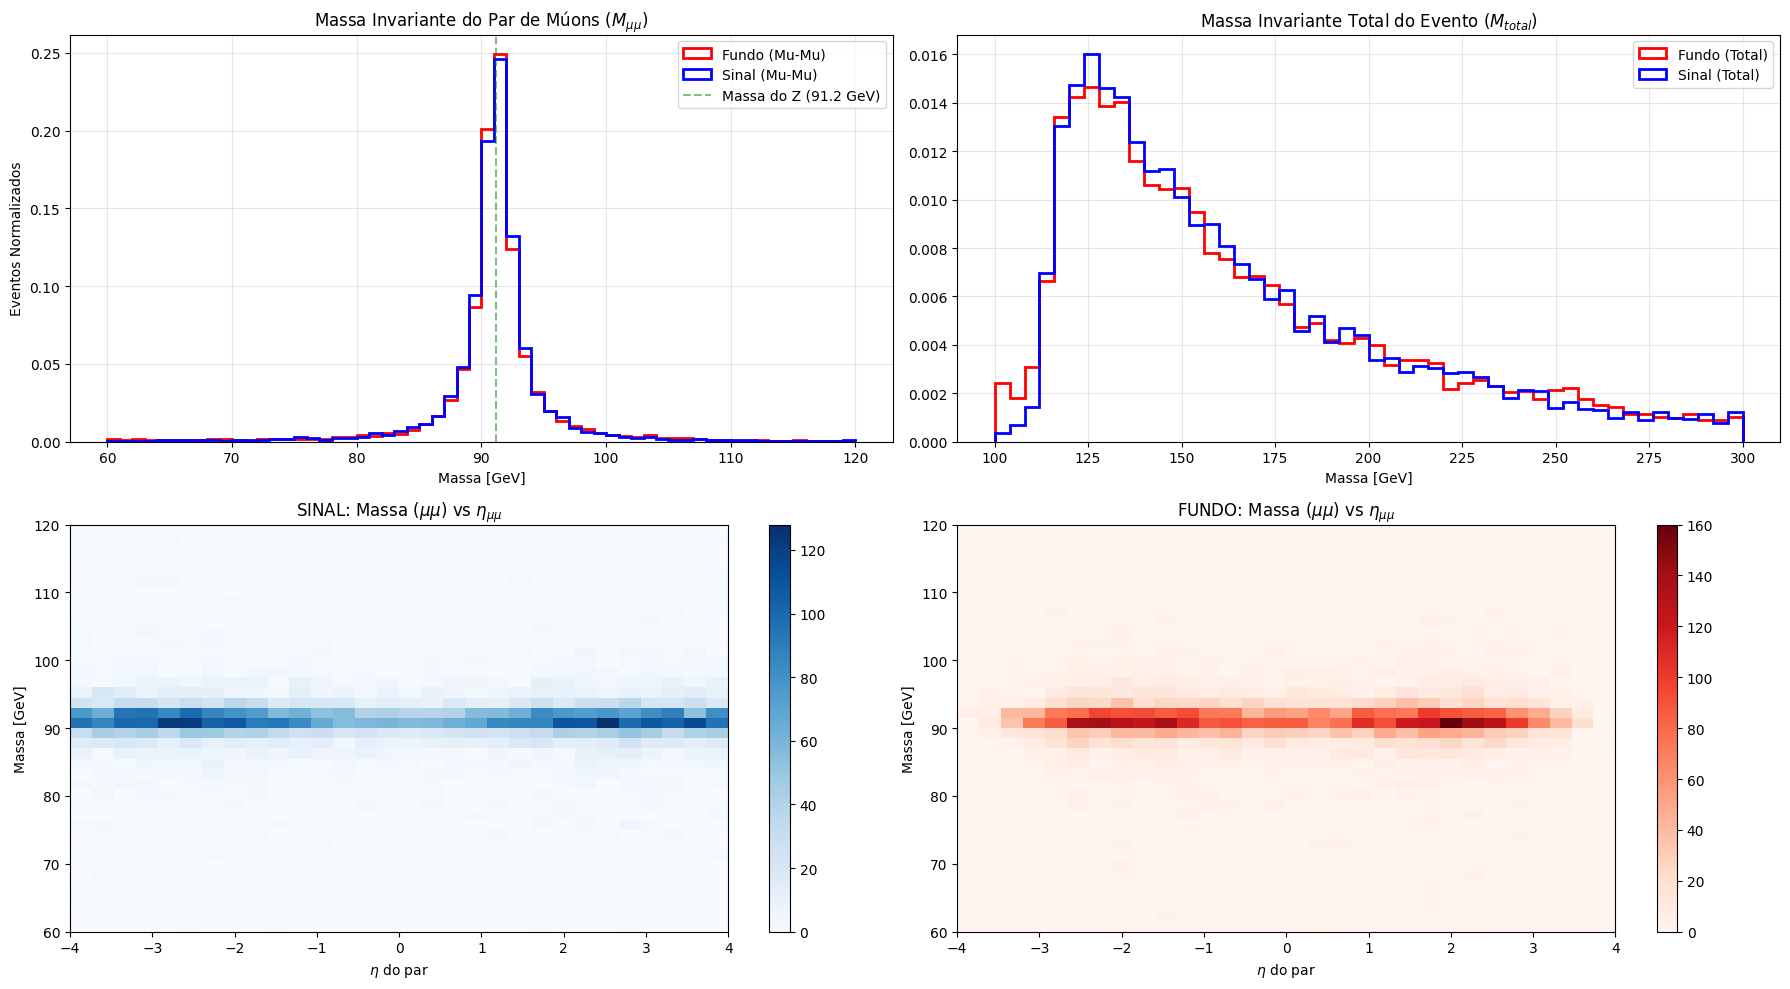

In [8]:
# --- [6] RECONSTRUÇÃO DE VARIÁVEIS (Massa Invariante) ---
import numpy as np
import matplotlib.pyplot as plt

def reconstruir_massas(eventos, label):
    m_pairs = []      # Massa do par de múons
    eta_pairs = []    # Eta do par de múons (para o plot 2D)
    m_total = []      # Massa total do evento (todas as partículas visíveis)

    ids_neutrinos = [12, 14, 16]

    for evento in eventos:
        # Filtra partículas visíveis (Status 1 e sem neutrinos)
        visiveis = [p for p in evento.particles if p.status == 1 and abs(p.id) not in ids_neutrinos]

        # --- 1. Massa Invariante do Par de Múons (Z -> mu mu) ---
        # Identifica múons
        muons = [p for p in visiveis if abs(p.id) == 13]

        # Se tivermos pelo menos 2 múons, calculamos a massa do par principal
        if len(muons) >= 2:
            # Pega os dois primeiros (assumindo serem os mais energéticos/principais)
            p1 = muons[0]
            p2 = muons[1]

            # Soma dos quadrimomentos
            E_pair = p1.e + p2.e
            Px_pair = p1.px + p2.px
            Py_pair = p1.py + p2.py
            Pz_pair = p1.pz + p2.pz

            # Cálculo da Massa Invariante
            M2 = E_pair**2 - (Px_pair**2 + Py_pair**2 + Pz_pair**2)
            M = np.sqrt(M2) if M2 > 0 else 0

            # Cálculo do Eta do sistema (do par)
            pt_pair = np.sqrt(Px_pair**2 + Py_pair**2)
            if pt_pair == 0:
                eta = 999 # Valor dummy para evitar erro
            else:
                eta = np.arcsinh(Pz_pair / pt_pair)

            m_pairs.append(M)
            eta_pairs.append(eta)

        # --- 2. Massa Invariante Total (Se houver > 2 partículas) ---
        if len(visiveis) > 2:
            E_tot = sum(p.e for p in visiveis)
            Px_tot = sum(p.px for p in visiveis)
            Py_tot = sum(p.py for p in visiveis)
            Pz_tot = sum(p.pz for p in visiveis)

            M2_tot = E_tot**2 - (Px_tot**2 + Py_tot**2 + Pz_tot**2)
            M_tot = np.sqrt(M2_tot) if M2_tot > 0 else 0
            m_total.append(M_tot)

    return m_pairs, eta_pairs, m_total

# --- Processamento ---
print("Reconstruindo massas invariantes...")
sinal_m_pair, sinal_eta, sinal_m_tot = reconstruir_massas(sinal_events, "Sinal")
fundo_m_pair, fundo_eta, fundo_m_tot = reconstruir_massas(fundo_events, "Fundo")

# --- PLOTAGEM ---
fig = plt.figure(figsize=(18, 10))

# Definições de estilo
bins_mass = 60
range_mass = (60, 120) # Focando na região do Z (91 GeV)

# 1. Histograma: Massa Invariante do Par de Múons
ax1 = fig.add_subplot(2, 2, 1)
ax1.hist(fundo_m_pair, bins=bins_mass, range=range_mass, histtype='step', label='Fundo (Mu-Mu)', color='red', density=True, linewidth=2)
ax1.hist(sinal_m_pair, bins=bins_mass, range=range_mass, histtype='step', label='Sinal (Mu-Mu)', color='blue', density=True, linewidth=2)
ax1.set_title(r"Massa Invariante do Par de Múons ($M_{\mu\mu}$)")
ax1.set_xlabel(r"Massa [GeV]")
ax1.set_ylabel("Eventos Normalizados")
ax1.axvline(91.2, color='green', linestyle='--', alpha=0.5, label='Massa do Z (91.2 GeV)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Histograma: Massa Invariante Total (> 2 partículas)
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(fundo_m_tot, bins=50, range=(100, 300), histtype='step', label='Fundo (Total)', color='red', density=True, linewidth=2)
ax2.hist(sinal_m_tot, bins=50, range=(100, 300), histtype='step', label='Sinal (Total)', color='blue', density=True, linewidth=2)
ax2.set_title(r"Massa Invariante Total do Evento ($M_{total}$)")
ax2.set_xlabel(r"Massa [GeV]")
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Histograma 2D: Sinal (Massa vs Eta)
ax3 = fig.add_subplot(2, 2, 3)
h3 = ax3.hist2d(sinal_eta, sinal_m_pair, bins=[30, 40], range=[[-4, 4], [60, 120]], cmap='Blues')
ax3.set_title(r"SINAL: Massa ($\mu\mu$) vs $\eta_{\mu\mu}$")
ax3.set_xlabel(r"$\eta$ do par")
ax3.set_ylabel(r"Massa [GeV]")
plt.colorbar(h3[3], ax=ax3)

# 4. Histograma 2D: Fundo (Massa vs Eta)
ax4 = fig.add_subplot(2, 2, 4)
h4 = ax4.hist2d(fundo_eta, fundo_m_pair, bins=[30, 40], range=[[-4, 4], [60, 120]], cmap='Reds')
ax4.set_title(r"FUNDO: Massa ($\mu\mu$) vs $\eta_{\mu\mu}$")
ax4.set_xlabel(r"$\eta$ do par")
ax4.set_ylabel(r"Massa [GeV]")
plt.colorbar(h4[3], ax=ax4)

plt.tight_layout()
plt.show()

============================== PARÂMETROS ==============================
Luminosidade: 10000.0 pb^-1
SINAL: Xsec=3.92e+02 pb | N=10000 | Peso=391.8680
FUNDO: Xsec=2.52e+02 pb | N=10000 | Peso=251.5034


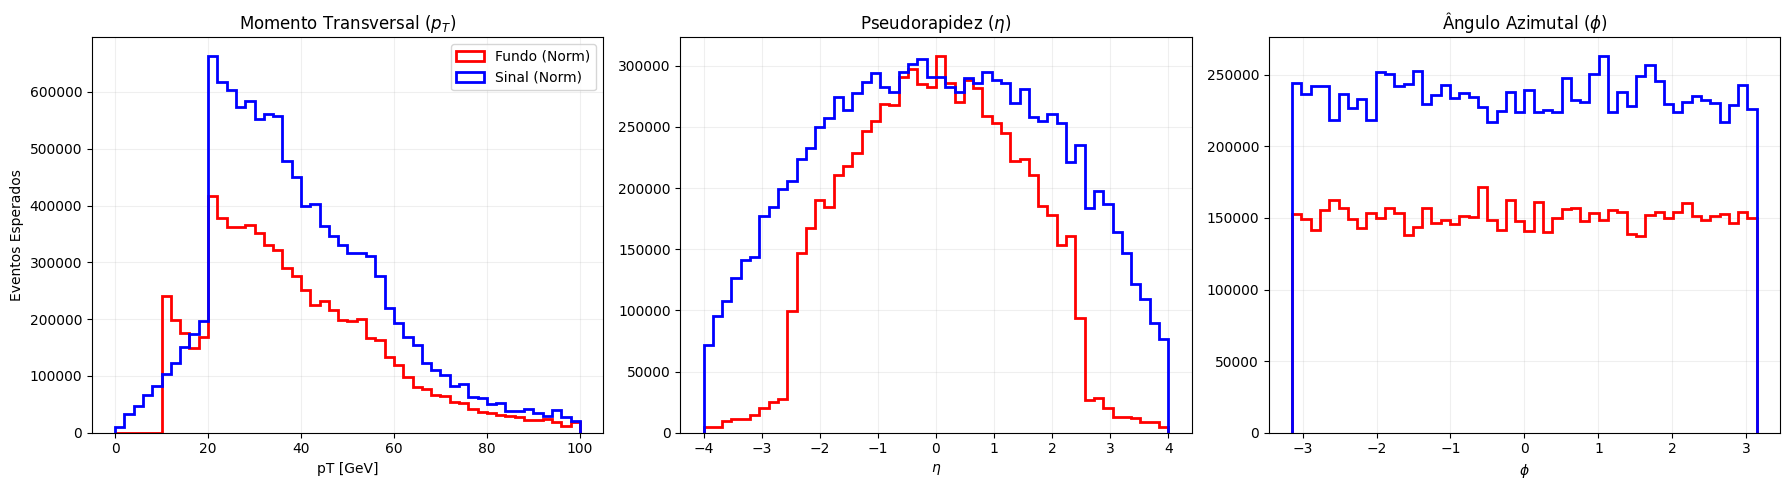

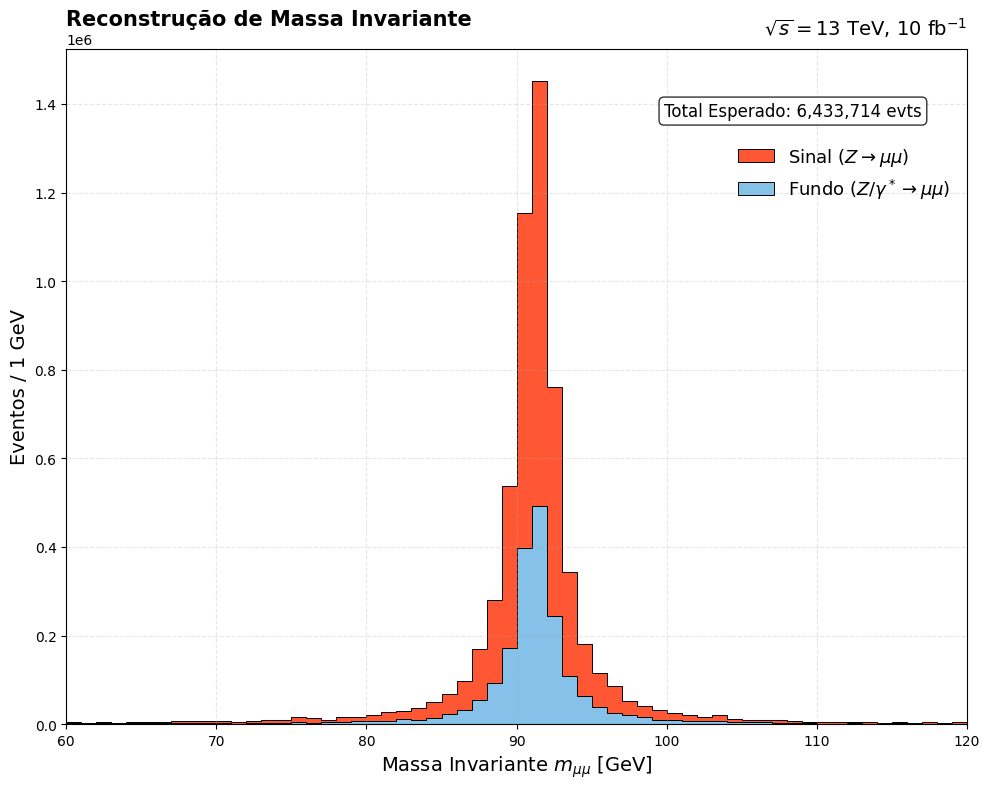

In [15]:
# --- [7] GRÁFICOS E VISUALIZAÇÃO (Normalização e Estilo CMS) ---
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# 1. Leitura da Seção de Choque e Cálculo dos Pesos (Yield)
# ==============================================================================
def ler_cross_section(arquivo_lhe):
    """Lê o cabeçalho do LHE para extrair a seção de choque (xsec) em pb."""
    try:
        with open(arquivo_lhe, 'r') as f:
            in_init = False
            for line in f:
                if '<init>' in line:
                    in_init = True
                    next(f) # Pula a primeira linha (feixes)
                    continue
                if '</init>' in line:
                    break
                if in_init:
                    # Formato: xsec, xerr, weight, id
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        return float(parts[0])
    except Exception as e:
        print(f"Erro ao ler {arquivo_lhe}: {e}")
    return 0.0

# Parâmetros
LUMINOSIDADE = 10000.0  # 10 fb^-1 = 10,000 pb^-1
N_SINAL_GEN = len(sinal_events) # Deve ser 10.000
N_FUNDO_GEN = len(fundo_events) # Deve ser 10.000

# Obtendo Xsec
xsec_sinal = ler_cross_section('sinal.lhe')
xsec_fundo = ler_cross_section('fundo.lhe')

# Calculando Peso (Weight) por evento
# Yield = (sigma * L) / N_gerado
w_sinal = (xsec_sinal * LUMINOSIDADE) / N_SINAL_GEN
w_fundo = (xsec_fundo * LUMINOSIDADE) / N_FUNDO_GEN

print(f"{'='*30} PARÂMETROS {'='*30}")
print(f"Luminosidade: {LUMINOSIDADE} pb^-1")
print(f"SINAL: Xsec={xsec_sinal:.2e} pb | N={N_SINAL_GEN} | Peso={w_sinal:.4f}")
print(f"FUNDO: Xsec={xsec_fundo:.2e} pb | N={N_FUNDO_GEN} | Peso={w_fundo:.4f}")

# Criando arrays de pesos para corresponder ao tamanho dos dados
# Para pT, Eta, Phi (30k partículas)
weights_pt_sinal  = np.full(len(pt_sinal), w_sinal)
weights_pt_fundo  = np.full(len(pt_fundo), w_fundo)
weights_eta_sinal = np.full(len(eta_sinal), w_sinal)
weights_eta_fundo = np.full(len(eta_fundo), w_fundo)
weights_phi_sinal = np.full(len(phi_sinal), w_sinal)
weights_phi_fundo = np.full(len(phi_fundo), w_fundo)

# Para Massa Invariante (10k eventos/pares)
weights_m_sinal = np.full(len(sinal_m_pair), w_sinal)
weights_m_fundo = np.full(len(fundo_m_pair), w_fundo)

# ==============================================================================
# 2. Plotagem Parte A: Cinemática Normalizada
# ==============================================================================
fig1, ax = plt.subplots(1, 3, figsize=(18, 5))
# Usamos 'step' aqui para comparar as formas das linhas
style_kin = dict(histtype='step', linewidth=2)

# pT
ax[0].hist(pt_fundo, bins=50, range=(0, 100), label='Fundo (Norm)', color='red', weights=weights_pt_fundo, **style_kin)
ax[0].hist(pt_sinal, bins=50, range=(0, 100), label='Sinal (Norm)', color='blue', weights=weights_pt_sinal, **style_kin)
ax[0].set_title(r"Momento Transversal ($p_T$)")
ax[0].set_ylabel("Eventos Esperados")
ax[0].set_xlabel("pT [GeV]")
ax[0].legend()
ax[0].grid(alpha=0.2)

# Eta
ax[1].hist(eta_fundo, bins=50, range=(-4, 4), label='Fundo', color='red', weights=weights_eta_fundo, **style_kin)
ax[1].hist(eta_sinal, bins=50, range=(-4, 4), label='Sinal', color='blue', weights=weights_eta_sinal, **style_kin)
ax[1].set_title(r"Pseudorapidez ($\eta$)")
ax[1].set_xlabel(r"$\eta$")
ax[1].grid(alpha=0.2)

# Phi
ax[2].hist(phi_fundo, bins=50, range=(-np.pi, np.pi), label='Fundo', color='red', weights=weights_phi_fundo, **style_kin)
ax[2].hist(phi_sinal, bins=50, range=(-np.pi, np.pi), label='Sinal', color='blue', weights=weights_phi_sinal, **style_kin)
ax[2].set_title(r"Ângulo Azimutal ($\phi$)")
ax[2].set_xlabel(r"$\phi$")
ax[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# ==============================================================================
# 3. Plotagem Parte B: Massa Invariante STACKED (Estilo CMS)
# ==============================================================================
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Dados Empilhados: Fundo primeiro (base), Sinal depois (topo)
dados_stack = [fundo_m_pair, sinal_m_pair]
pesos_stack = [weights_m_fundo, weights_m_sinal]
labels_stack = [r'Fundo ($Z/\gamma^* \to \mu\mu$)', r'Sinal ($Z \to \mu\mu$)']

# Cores: Fundo 'Cool' (Azul/Cinza), Sinal 'Hot' (Vermelho/Laranja) para destaque
# Inspirado na imagem do CMS
colors_stack = ['#85C1E9', '#FF5733'] # Azul Claro, Vermelho Vibrante

# O PLOT PRINCIPAL
# histtype='stepfilled': Preenche a área (sólido)
# edgecolor='black': Desenha o contorno preto nas barras (importante para o visual)
ax2.hist(dados_stack, bins=60, range=(60, 120), stacked=True, weights=pesos_stack,
         label=labels_stack, color=colors_stack,
         histtype='stepfilled', alpha=1.0, edgecolor='black', linewidth=0.7)

# Detalhes Cosméticos
ax2.set_title("Reconstrução de Massa Invariante", fontsize=15, loc='left', fontweight='bold')
ax2.set_xlabel(r"Massa Invariante $m_{\mu\mu}$ [GeV]", fontsize=14)
ax2.set_ylabel(f"Eventos / 1 GeV", fontsize=14)
ax2.set_xlim(60, 120)

# Labels no topo (Padrão CMS)

# Texto direito (Energia e Lumi)
plt.text(1.0, 1.02, r"$\sqrt{s} = 13$ TeV, 10 fb$^{-1}$", transform=ax2.transAxes,
         fontsize=14, ha='right')

# Estatística Total
total_yield = np.sum(weights_m_sinal) + np.sum(weights_m_fundo)
info_box = f"Total Esperado: {total_yield:,.0f} evts"
plt.text(0.95, 0.90, info_box, transform=ax2.transAxes, ha='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)

ax2.legend(fontsize=13, frameon=False, loc='upper right', bbox_to_anchor=(1, 0.88))
ax2.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### [8] Comentários

A proporção observada entre os histogramas normalizados faz sentido físico, pois a amostra de fundo Drell-Yan possui uma seção de choque comparável à do sinal na região analisada. Isso ocorre porque o processo Drell-Yan é o mecanismo inclusivo que engloba tanto a troca de fótons virtuais quanto a própria produção ressonante do Z, resultando em um número de eventos esperados da mesma ordem de grandeza após a normalização.

Em relação à distribuição de massa invariante, a estrutura é caracterizada por um pico proeminente centrado em aproximadamente 91,2 GeV, o que confirma a presença de uma partícula instável, o Bóson Z. O alargamento observado ao redor desse valor reflete a largura de decaimento natural da partícula somada à resolução simulada do detector, enquanto a semelhança entre as curvas de sinal e fundo nessa janela reforça que a produção ressonante domina o processo eletrofraco nessa escala de energia.